In [1]:
import numpy as np
import pandas as pd
import tensorflow
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import sklearn
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

In [3]:
df.shape

(420551, 15)

Index	Features	Format	Description
1	Date Time	01.01.2009 00:10:00	Date-time reference
2	p (mbar)	996.52	The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3	T (degC)	-8.02	Temperature in Celsius
4	Tpot (K)	265.4	Temperature in Kelvin
5	Tdew (degC)	-8.9	Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6	rh (%)	93.3	Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7	VPmax (mbar)	3.33	Saturation vapor pressure
8	VPact (mbar)	3.11	Vapor pressure
9	VPdef (mbar)	0.22	Vapor pressure deficit
10	sh (g/kg)	1.94	Specific humidity
11	H2OC (mmol/mol)	3.12	Water vapor concentration
12	rho (g/m ** 3)	1307.75	Airtight
13	wv (m/s)	1.03	Wind speed
14	max. wv (m/s)	1.75	Maximum wind speed
15	wd (deg)	152.3	Wind direction in degrees

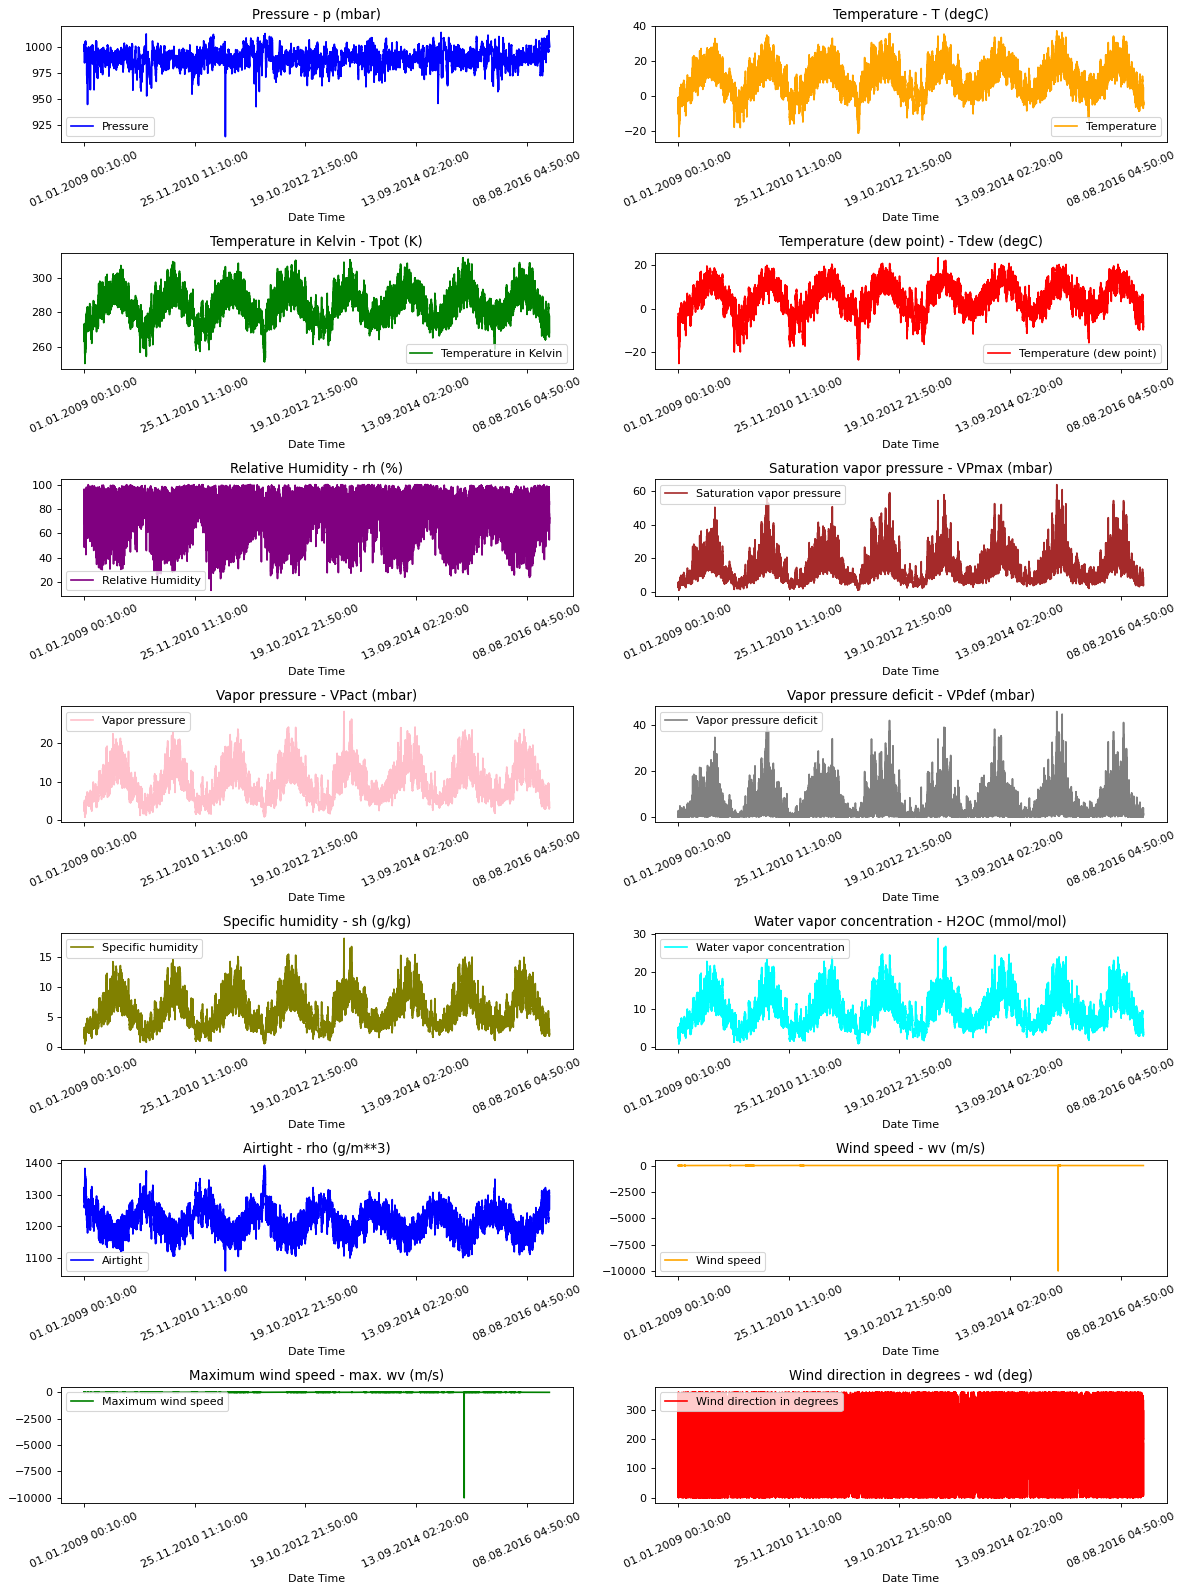

In [4]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

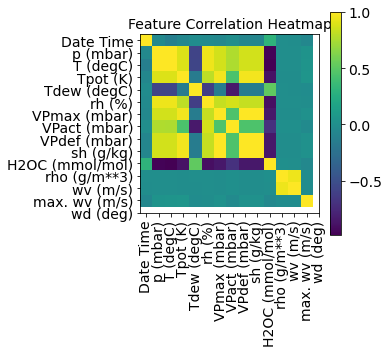

In [5]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

In [6]:
df.shape

(420551, 15)

In [7]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720 #We are tracking data from past 720 timestamps (720/6=120 hours =5 days). 
future = 72 #This data will be used to predict the temperature after 72 timestamps (72/6=12 hours)
learning_rate = 0.001
batch_size = 256
epochs = 1


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [8]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
Date Time,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03
01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72
01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19
01.01.2009 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34
01.01.2009 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32


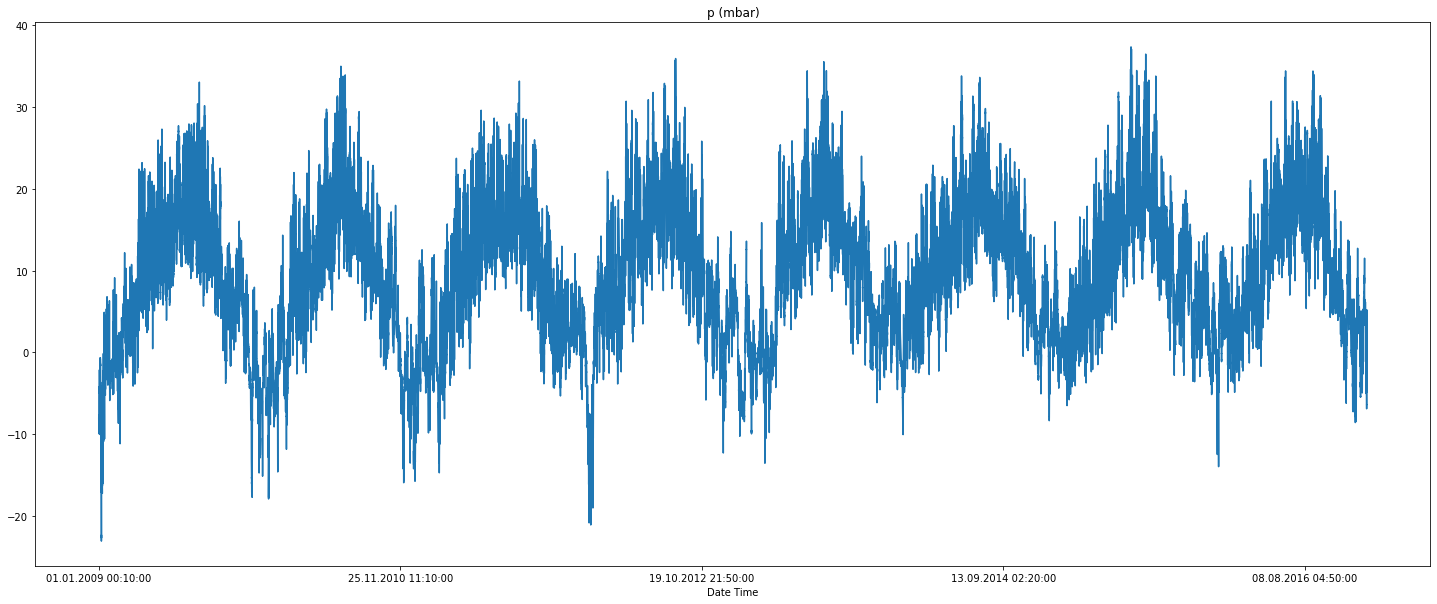

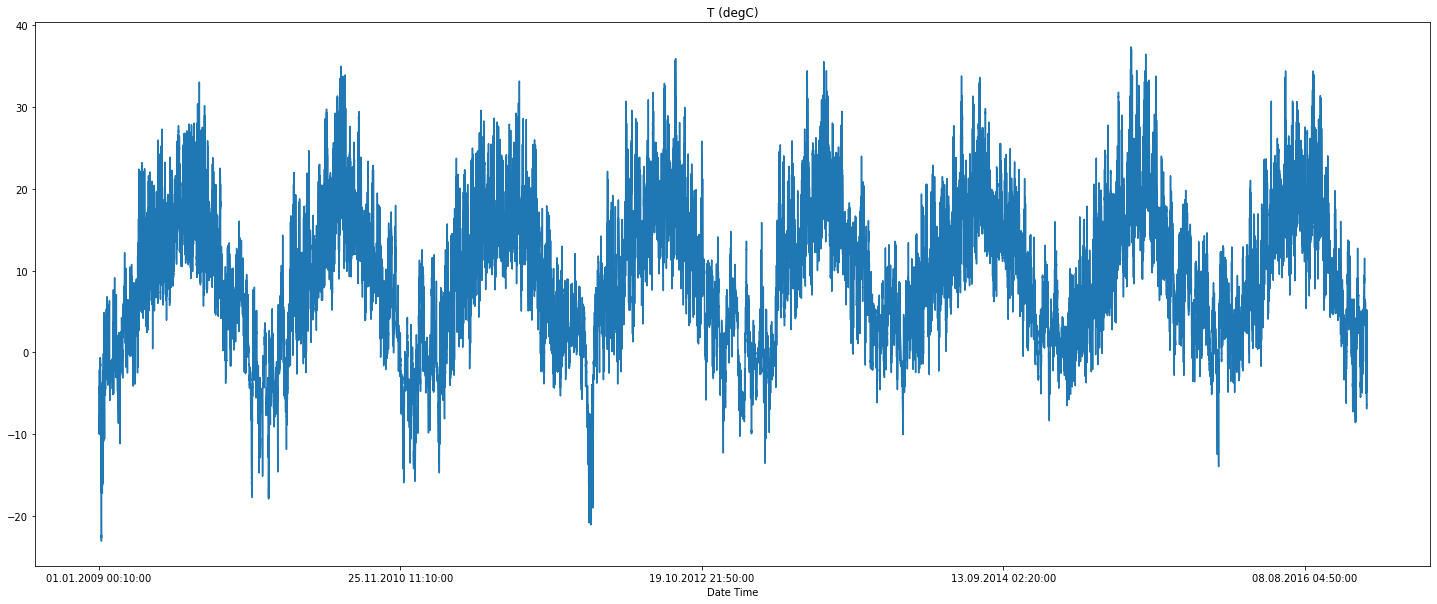

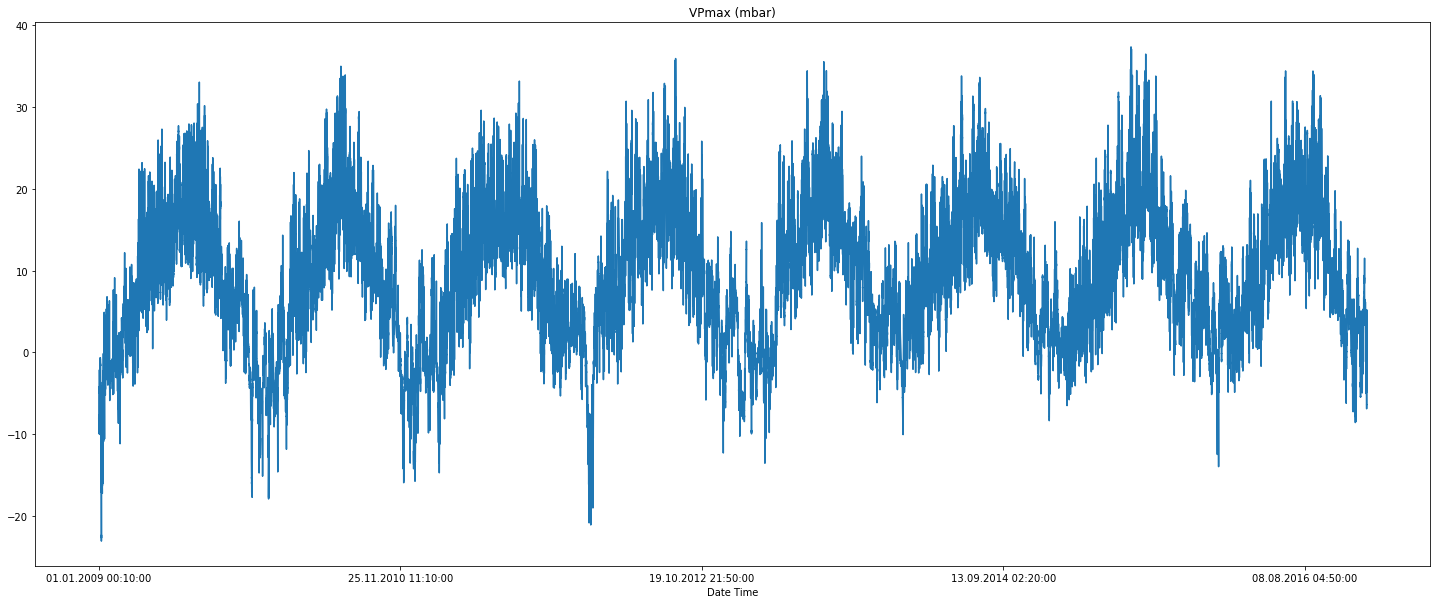

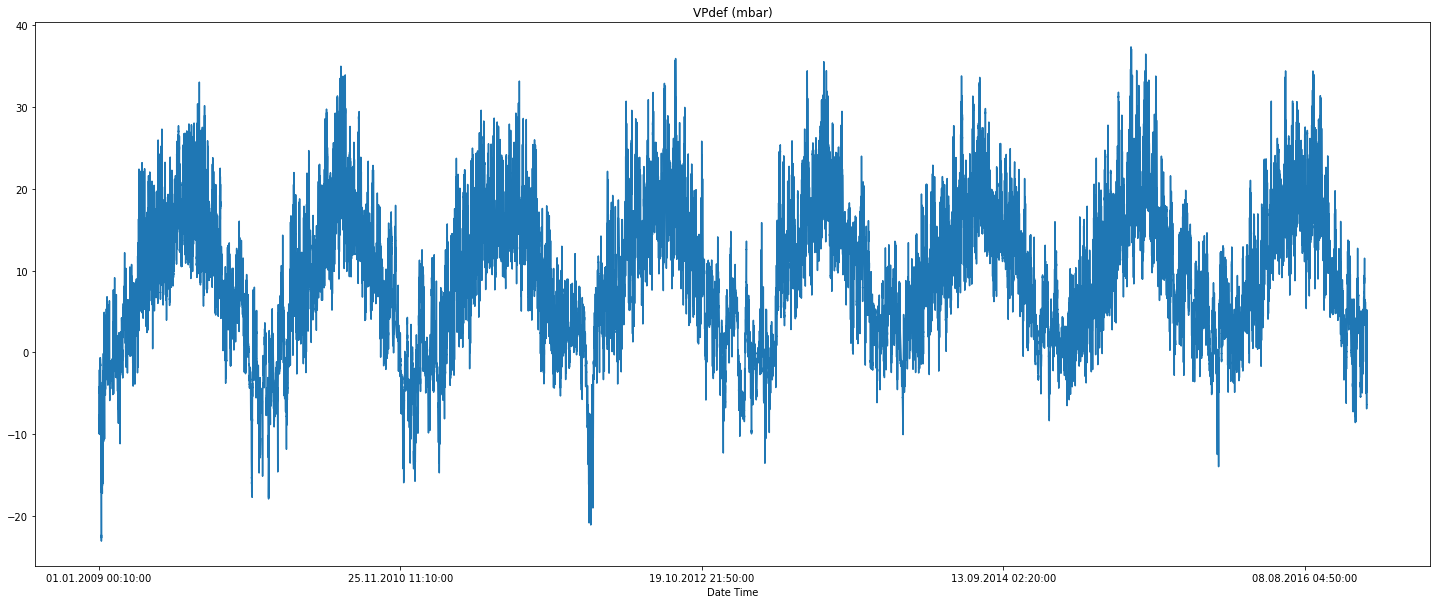

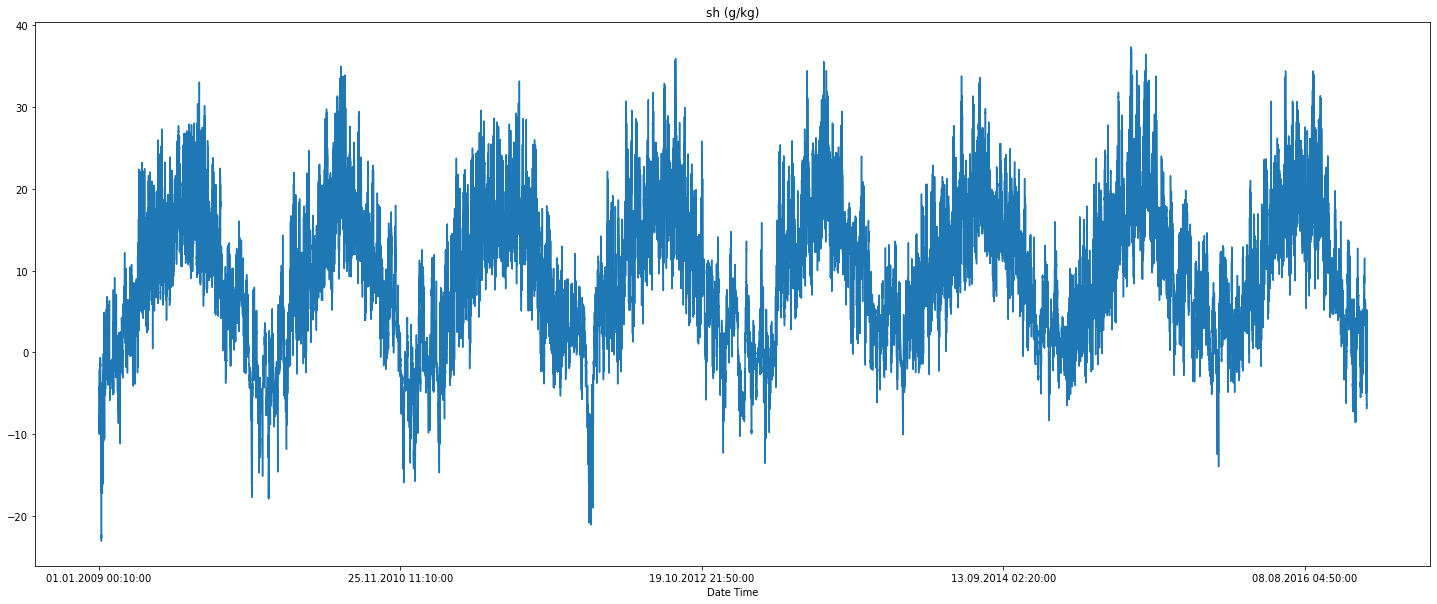

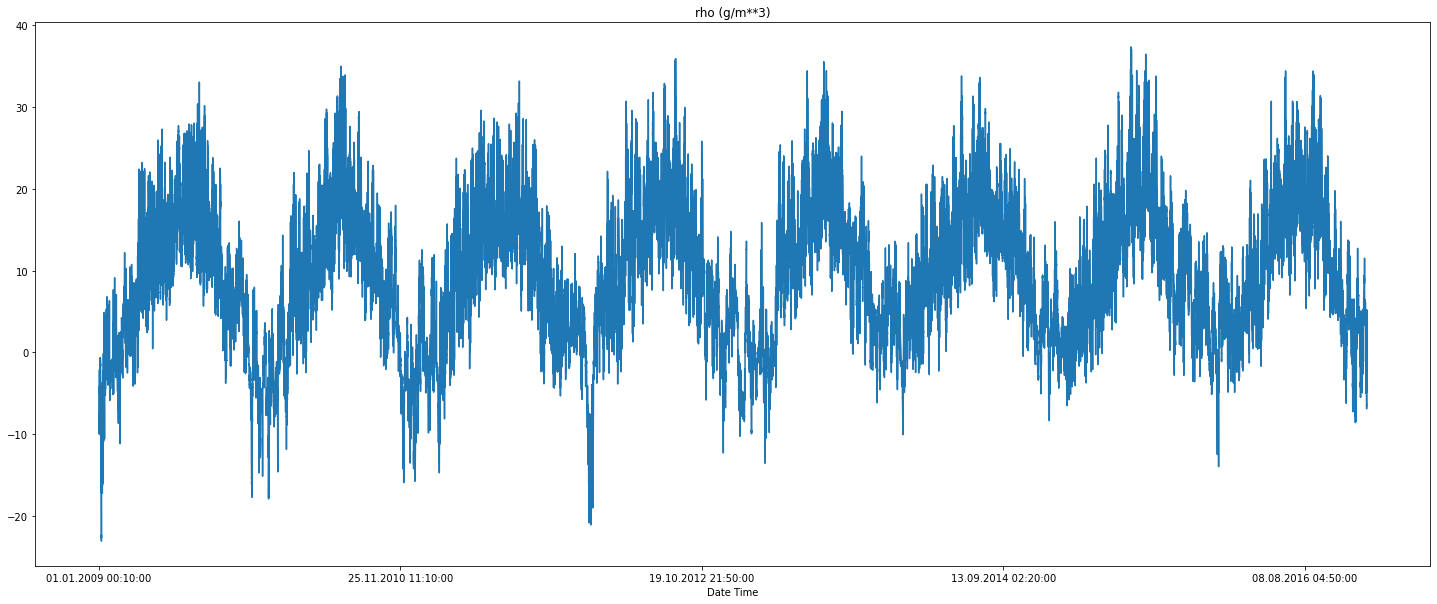

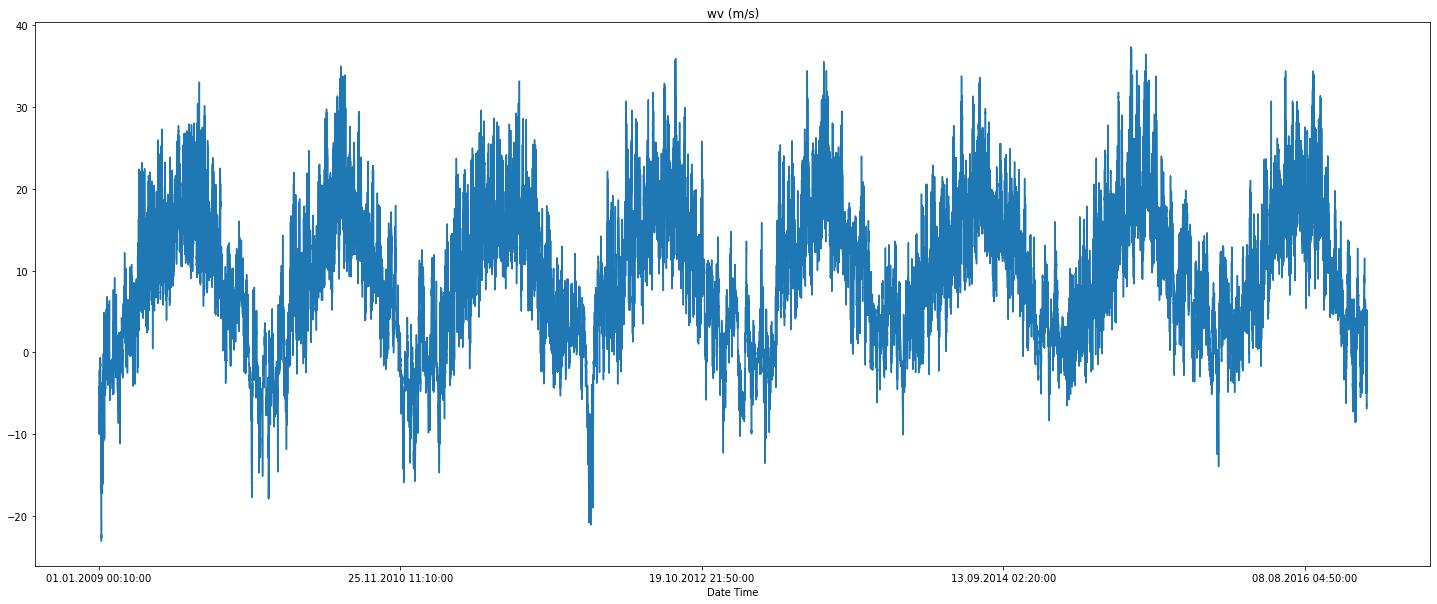

In [9]:
for c in features.columns:
    features['T (degC)'].plot(figsize=(25,10), title=c)
    plt.show()

In [10]:
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944


In [11]:
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]
pd.DataFrame(train_data).head()

,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944


In [12]:
start = past + future
print(start)
end = start + train_split
print(end)
x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)
print(sequence_length)

792
301485
120


In [13]:
pd.DataFrame(train_data).values[792]

array([ 1.10250914e+00, -2.74582061e+00, -1.49560433e+00, -7.55172932e-01,
       -1.85049210e+00,  3.09315405e+00,  4.40616529e-04])

In [14]:
y_train.head()

,1
792,-2.745821
793,-2.701814
794,-2.641594
795,-2.597587
796,-2.509573


This function takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as length of the sequences/windows, spacing between two sequence/windows, etc., to produce batches of timeseries inputs and targets.

Arguments
data	Numpy array or eager tensor containing consecutive data points (timesteps). Axis 0 is expected to be the time dimension.
targets	Targets corresponding to timesteps in data. It should have same length as data. targets[i] should be the target corresponding to the window that starts at index i (see example 2 below). Pass None if you don't have target data (in this case the dataset will only yield the input data).
sequence_length	Length of the output sequences (in number of timesteps).
sequence_stride	Period between successive output sequences. For stride s, output samples would start at index data[i], data[i + s], data[i + 2 * s], etc.
sampling_rate	Period between successive individual timesteps within sequences. For rate r, timesteps data[i], data[i + r], ... data[i + sequence_length] are used for create a sample sequence.
batch_size	Number of timeseries samples in each batch (except maybe the last one).
shuffle	Whether to shuffle output samples, or instead draw them in chronological order.
seed	Optional int; random seed for shuffling.
start_index	Optional int; data points earlier (exclusive) than start_index will not be used in the output sequences. This is useful to reserve part of the data for test or validation.
end_index	Optional int; data points later (exclusive) than end_index will not be used in the output sequences. This is useful to reserve part of the data for test or validation.

In [15]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)
for batch in dataset_train:
    inputs, targets = batch
    print(inputs.shape)
    print(targets.shape)

(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 7)
(256, 1)
(256, 120, 

In [16]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


In [17]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [18]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=4,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/4
1172/1172 [==============================] - ETA: 0s - loss: 0.1993
Epoch 1: val_loss improved from inf to 0.14513, saving model to model_checkpoint.h5
1172/1172 [==============================] - 323s 271ms/step - loss: 0.1993 - val_loss: 0.1451
Epoch 2/4
1172/1172 [==============================] - ETA: 0s - loss: 0.1259
Epoch 2: val_loss improved from 0.14513 to 0.14507, saving model to model_checkpoint.h5
1172/1172 [==============================] - 265s 226ms/step - loss: 0.1259 - val_loss: 0.1451
Epoch 3/4
1172/1172 [==============================] - ETA: 0s - loss: 0.1161
Epoch 3: val_loss did not improve from 0.14507
1172/1172 [==============================] - 301s 257ms/step - loss: 0.1161 - val_loss: 0.1454
Epoch 4/4
1172/1172 [==============================] - ETA: 0s - loss: 0.1101
Epoch 4: val_loss did not improve from 0.14507
1172/1172 [==============================] - 286s 244ms/step - loss: 0.1101 - val_loss: 0.1493


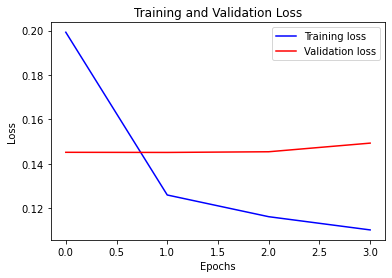

In [19]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

8/8 [==============================] - 2s 26ms/step


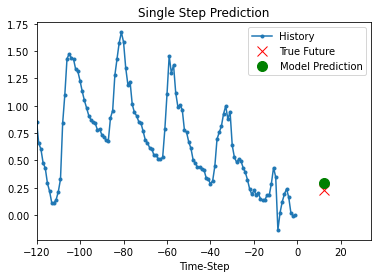

8/8 [==============================] - 0s 25ms/step


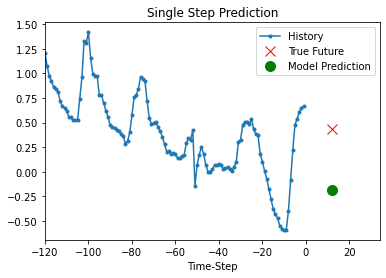

8/8 [==============================] - 0s 24ms/step


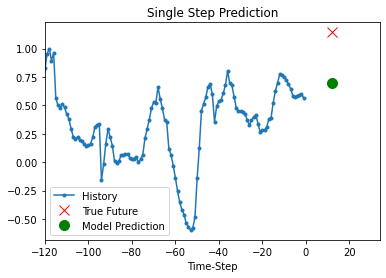

8/8 [==============================] - 0s 26ms/step


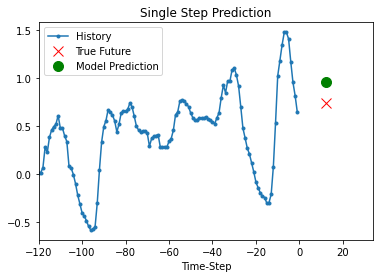

8/8 [==============================] - 0s 25ms/step


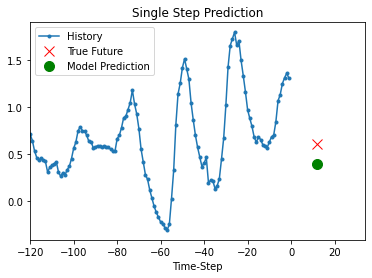

In [20]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )